### CS60050 MACHINE LEARNING <br> ASSIGNMENT 02 - K-MEANS CLUSTERING <br> 20 OCTOBER 2021
***Amrta Chaurasia (19EE10004)***<br>***Nakul Aggarwal (19CS10044)***

In [1]:
import csv
from math import log2
from random import shuffle, randint
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# load dataset from the csv file whose location is provided as the arguement
def Load_Dataset ( loc ) :
    global data_samples
    data_samples = [ ]
    attributes = None
    with open(loc) as csv_file :
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader :
            attributes = list(row)[:-1]
            sample = np.array([eval(t) for t in row.values()][:-1])
            data_samples.append((sample, eval(row['Outcome'])))
        
        # Standardization of data (Feature Scaling) -- read the report for further information
        means = np.mean(np.array([x for x, _ in data_samples]), axis = 0)
        sds = np.std(np.array([x for x, _ in data_samples]), axis = 0)
        for i, att in enumerate(attributes) :
            print(' ATTRIBUTE :', att, '| MEAN :', round(means[i], 4), '| STD DEV :', round(sds[i], 4))
        data_samples = [ ((x - means) / sds , y) for x, y in data_samples ]

In [3]:
# This function returns the k centers selected from the train_data dataset using
# k-means++ heuristic. If the seed given as arguement is None then it is randomly
# selected from the dataset.
def KMeans_Plus_Plus_Initial_Centers ( train_data , k , seed = None ) :
    centers = []
    
    if seed is None :
        first_center_id = randint(0, len(train_data)-1)
        centers.append(train_data[first_center_id][0])
    else : centers.append(seed)
    
    for i in range(1, k) :
        prob_dist = []
        for j in range(len(train_data)) :
            least_dist_sq = float('inf')
            for cent in centers :
                d = np.linalg.norm(cent - train_data[j][0])
                d = d * d
                least_dist_sq = min(least_dist_sq, d)
            prob_dist.append(least_dist_sq)
        
        f = sum(prob_dist)
        prob_dist = np.array(prob_dist)
        prob_dist = prob_dist / f
        
        center_id = np.random.choice(list(range(len(train_data))), p = prob_dist)
        centers.append(train_data[center_id][0])
    
    return centers

In [4]:
# J_clust is the objective function that the k-means clustering algorithm aims at 
# minimizing for a particular k. This function returns the value of the obj. function
# that is the mean squared error (MSE) between the data samples and the centers of 
# the respective clusters they belong to.
def J_clust ( clusters , centers ) :
    k = len(centers)
    j_clust = 0.0
    N = 0
    for i in range(k) :
        N += len(clusters[i])
        for x in clusters[i] :
            d = np.linalg.norm(centers[i] - x[0])
            d = d * d
            j_clust += d
    return round(j_clust/N, 6)

In [5]:
# This function runs the k-means clustering algorithm on the train_data dataset.
# +++ ARGUEMENTS +++
#        -- train_data : a list of feature-class pairs that need to to be clustered.
#        -- k : cluster size, i.e, the number of clusters into which the data samples are clustered.
#        -- init : initialization setting for selecting the initial cluster centers.
#                  * KMEANS++ (default) : centers initialized by the k-means++ heuristic 
#                                         seeded by the arguement 'seed' (if not None).
#                  * RANDOM : k centers chosen randomly from the train_data.
#                  * CUSTOM : k centers initialized by the arguement 'initial_centers' (if not None).
#        -- initial_centers : Initial clsuter centers provided as an arguement that are 
#                             used only in the CUSTOM setting. 
#        -- seed : Seed for the k-means++ center-initialization heuristic that is used
#                  only in the KMEANS++ setting.
#        -- verbose : If true, the value of the objective function is printed at every iteration.
def KMeans ( train_data , k , init = 'kmeans++' , initial_centers = None , seed = None , verbose = False ) :
    centers = None
    if init == 'custom' :
        if initial_centers is None : return None
        centers = initial_centers
    elif init == 'kmeans++' :
        centers = KMeans_Plus_Plus_Initial_Centers(train_data, k, seed)
    elif init == 'random' :
        shuffle(train_data)
        centers = [ train_data[i][0] for i in range(k) ]
    else : return None
    
    J_clusts = [ ]
    prev_J_clust = float('inf')
    clusters = None
    it = 1
    
    while True :
        clusters = [ [] for t in range(k) ]
        
        # STEP 1. -- CLSUTER ASSIGNMENT
        for x in train_data :
            least_dist = float('inf')
            clust = -1
            for c in range(k) :
                d = np.linalg.norm(centers[c] - x[0])
                if d < least_dist :
                    least_dist = d
                    clust = c
            clusters[clust].append(x)
        
        # STEP 2. -- UPDATING CLUSTER CENTERS
        for c in range(k) :
            if len(clusters[c]) == 0 : continue
            new_cent = sum([t[0] for t in clusters[c]])
            new_cent = new_cent / len(clusters[c])
            centers[c] = new_cent
        
        # STEP 3. -- RE-COMPUTE OBJECTIVE FUNCTION
        j_clust = J_clust(clusters, centers)
        J_clusts.append(j_clust)
        
        if ( verbose ) :
            print(' ITERATION', it, ' | J_CLUST :', j_clust)
        
        if abs(j_clust - prev_J_clust) < 1e-6 : break
        # terminate the algorithm if the change in the value of 
        # objective function is insignificant.
        
        prev_J_clust = j_clust
        it += 1
    
    return centers, clusters, J_clusts

In [6]:
# This function returns the index/ID of the cluster to which the given
# sample belong to. 'centers' is the centers of the clusters derived from
# the kmeans clustering algorithm
def Get_Center_ID ( sample , centers ) :
    cent = -1
    least_dist = float('inf')
    for c in range(len(centers)) :
        d = np.linalg.norm(centers[c] - sample[0])
        if d < least_dist :
            least_dist = d
            cent = c
    return cent

In [7]:
# This function returns the entropy of the values observed for a variable with
# the given probability distribution of values -- 'dist'
def Entropy ( dist ) :
    ent = 0
    for p in dist :
        if p == 0 : continue
        ent += -1 * p * log2(p)
    return ent

In [8]:
# This function computes and returns the Rand Index (external index).
# Read the report for more information.
def RI ( data , centers ) :
    l = len(data)
    a, b, N = 0, 0, 0
    center_ids = [ Get_Center_ID(data[i], centers) for i in range(len(data)) ]
    for i in range(l) :
        for j in range(i+1, l) :
            N += 1
            a += ((center_ids[i] == center_ids[j]) and (data[i][1] == data[j][1]))
            b += ((center_ids[i] != center_ids[j]) and (data[i][1] != data[j][1]))
    ri = (a + b) / N
    return round(ri, 4)

# This function computes and returns the Adjusted Rand Index (external index).
# Read the report for more information.
def ARI ( clusters ) :
    k = len(clusters)
    contingency_table = np.zeros((k, 2))
    
    for c in range(k) :
        pos = len([t for t in clusters[c] if t[1] == 1])
        neg = len(clusters[c]) - pos
        contingency_table[c][0] = pos
        contingency_table[c][1] = neg
    
    n = sum(sum(contingency_table))
    numer = sum(sum(contingency_table * (contingency_table - 1) / 2))
    
    A = np.sum(contingency_table, axis=1)
    B = np.sum(contingency_table, axis=0)
    
    t1 = sum(A * (A - 1) / 2)
    t2 = sum(B * (B - 1) / 2)
    n_C_2 = n * (n - 1) / 2
    numer -= (t1 * t2) / n_C_2
    
    denom = (t1 + t2) / 2
    denom -= (t1 * t2) / n_C_2
    
    ari = numer / denom
    return round(ari, 4)

In [9]:
# This function computes and returns the Mutual Information (external index).
# Refer to the lecture slides "Unsupervised Learning" by Prof. Jayanta Mukhopadhyay
# for more information.
def MI ( clusters ) :
    k = len(clusters)
    contingency_table = np.zeros((k, 2))
    
    for c in range(k) :
        pos = len([t for t in clusters[c] if t[1] == 1])
        neg = len(clusters[c]) - pos
        contingency_table[c][0] = pos
        contingency_table[c][1] = neg
    
    N = sum(sum(contingency_table))
    A = np.sum(contingency_table, axis=1)
    B = np.sum(contingency_table, axis=0)
    
    mi = 0.0
    for i in range(k) :
        for j in range(2) :
            if contingency_table[i][j] == 0 : continue
            t = N * contingency_table[i][j] / (A[i] * B[j])
            mi += contingency_table[i][j] * log2(t) / N
    
    return round(mi, 4)

# This function computes and returns the Normalized Mutual Information (external index).
# Refer to the lecture slides "Unsupervised Learning" by Prof. Jayanta Mukhopadhyay
# for more information.
def NMI ( clusters ) :
    k = len(clusters)
    contingency_table = np.zeros((k, 2))
    
    for c in range(k) :
        pos = len([t for t in clusters[c] if t[1] == 1])
        neg = len(clusters[c]) - pos
        contingency_table[c][0] = pos
        contingency_table[c][1] = neg
    
    N = sum(sum(contingency_table))
    A = np.sum(contingency_table, axis=1)
    B = np.sum(contingency_table, axis=0)
    
    entropy_clusters = Entropy(A / sum(A))
    entropy_classes = Entropy(B / sum(B))
    
    nmi = 2 * MI(clusters) / (entropy_clusters + entropy_classes)
    return round(nmi, 4)

In [10]:
# This function computes and returns the Homogeneity metric.
# Read the report for more information.
def Homogeneity ( clusters ) :
    k = len(clusters)
    contingency_table = np.zeros((k, 2))
    
    for c in range(k) :
        pos = len([t for t in clusters[c] if t[1] == 1])
        neg = len(clusters[c]) - pos
        contingency_table[c][0] = pos
        contingency_table[c][1] = neg
    
    N = sum(sum(contingency_table))
    A = np.sum(contingency_table, axis=1)
    B = np.sum(contingency_table, axis=0)
    
    entropy_C_given_K = 0.0
    for c in range(2) :
        for t in range(k) :
            if contingency_table[t][c] == 0 : continue
            p = contingency_table[t][c] / A[t]
            entropy_C_given_K += -1 * contingency_table[t][c] * log2(p) / N
    
    entropy_C = Entropy(B / N)
    h = 1 - entropy_C_given_K / entropy_C
    return round(h, 4)

# This function computes and returns the Completeness metric.
# Read the report for more information.
def Completeness ( clusters ) :
    k = len(clusters)
    contingency_table = np.zeros((k, 2))
    
    for c in range(k) :
        pos = len([t for t in clusters[c] if t[1] == 1])
        neg = len(clusters[c]) - pos
        contingency_table[c][0] = pos
        contingency_table[c][1] = neg
    
    N = sum(sum(contingency_table))
    A = np.sum(contingency_table, axis=1) # clusters
    B = np.sum(contingency_table, axis=0) # class
    
    entropy_K_given_C = 0.0
    for t in range(k) :
        for c in range(2) :
            if contingency_table[t][c] == 0 : continue
            p = contingency_table[t][c] / B[c]
            entropy_K_given_C += -1 * contingency_table[t][c] * log2(p) / N
    
    entropy_K = Entropy(A / N)
    c = 1 - entropy_K_given_C / entropy_K
    return round(c, 4)

# This function computes and returns the V_Measure metric.
# Read the report for more information.
def V_Measure ( clusters ) :
    h = Homogeneity(clusters)
    c = Completeness(clusters)
    v = 2 * h * c / (h + c)
    return round(v, 4)

In [11]:
# This function and computes and returns the silhouette coefficient
# for a single sample x wrt to the clustering defined by 'centers' and
# 'clusters', i.e, it returns s(x) = (b(x)-a(x))/max(b(x),a(x)), where
# b(x) : min. avg. distance of points of other cluster(s) from x.
# a(x) : avg. distance of points with the cluster from x.
def Silhouette_Coefficient_Single ( x , centers , clusters ) :
    k = len(centers)
    center_id = Get_Center_ID(x, centers)
    a_x = 0
    for y in clusters[center_id] :
        a_x += np.linalg.norm(x[0] - y[0])
    if len(clusters[center_id]) == 1 : a_x = 0
    else : a_x /= len(clusters[center_id]) - 1
    
    b_x = float('inf')
    for c in range(k) :
        if len(clusters[c]) == 0 : continue
        if c == center_id : continue
        avg_dist = 0
        for y in clusters[c] :
            avg_dist += np.linalg.norm(x[0] - y[0])
        avg_dist /= len(clusters[c])
        b_x = min(b_x, avg_dist)
        
    return (b_x - a_x) / max(a_x, b_x)

# This function returns the silhouette coefficient (internal index) for the entire 
# dataset, i.e, average of silhouette coefficients for each data sample in the dataset.
def Silhouette_Coefficient ( train_data , centers , clusters ) :
    s = sum([Silhouette_Coefficient_Single(x, centers, clusters) for x in train_data])
    s /= len(train_data)
    return round(s, 4)

In [12]:
# This function computes and returns the Calinski Harabasz Index (internal index).
# CH(k) = ((J(1)-J(k)) / (k-1)) / (J(k) / (n-k)), where J(i) is the value of the
# objective function J_clust (MSE) when cluster size (no. of clusters) is i.
def Calinski_Harabasz_Index ( train_data , centers , clusters ) :
    k = len(centers)
    N = len(train_data)
    mean = np.sum([t[0] for t in train_data], axis = 0) / len(train_data)
    J_1 = J_clust([train_data], [mean])
    J_k = J_clust(clusters, centers)
    ch_idx = (J_1 - J_k) / (k - 1)
    ch_idx = (N - k) * ch_idx / J_k
    return round(ch_idx, 4)

In [13]:
# This function computes and returns the Davies Bouldin Index (internal index).
# Read the report for more information.
def Davies_Bouldin_Index ( train_data , centers , clusters ) :
    cluster_diameters = [ ]
    k = len(clusters)
    for c in range(k) :
        if len(clusters[c]) == 0 : 
            cluster_diameters.append(0)
            continue
        diam = 0.0
        for x in clusters[c] :
            diam += np.linalg.norm(x[0] - centers[c])
        diam /= len(clusters[c])
        cluster_diameters.append(diam)
    
    dbi = 0
    for i in range(k) :
        f = -1
        for j in range(k) :
            if j == i : continue
            R_ij = (cluster_diameters[i] + cluster_diameters[j]) / np.linalg.norm(centers[i] - centers[j])
            f = max(f, R_ij)
        dbi += f
    dbi /= k
    
    return round(dbi, 4)

In [14]:
# This function runs Wangs_Cross_Validation_Method for a particular value of k, with
# 'count' permutations (default 10), and S1, S2, S3 randomly split in 3:3:4 ratio for each
# permutation. It returns the average disagreements ratio over the 'count' permutations.
def Wangs_Cross_Validation_Method_Avg_Disagreement_Ratio ( train_data , k , count = 10 ) :
    N = len(train_data)
    S1_size = S2_size = round(N * 0.3)
    S3_size = N - S1_size - S2_size
    avg_disagreement_ratio = 0
    
    # Permute the data 'count' times
    for _ in range(count) :
        # STEP 1. Randomly split data into S1, S2, S3 such that |S1| = |S2|
        shuffle(train_data)
        S1 = train_data[:S1_size]
        S2 = train_data[S1_size:S1_size+S2_size]
        S3 = train_data[S1_size+S2_size:]
        
        # STEP 2. Perform k-means on S1 and S2
        centers_S1, clusters_S1, _ = KMeans(S1, k)
        centers_S2, clusters_S2, _ = KMeans(S2, k)
        
        # STEP 3. Assign the clusters for the data samples in the set S3
        clust_assign_S1 = [Get_Center_ID(x, centers_S1) for x in S3]
        clust_assign_S2 = [Get_Center_ID(x, centers_S2) for x in S3]
        
        # STEP 4. Compute the fraction of all the pairs of S3 that dsagree, i.e,
        #.        that are either in same cluster in S1 and different S2 or vice-versa.
        disagreement_count = 0
        for i in range(S3_size) :
            for j in range(i+1, S3_size) :
                same_clust_for_S1 = (clust_assign_S1[i] == clust_assign_S1[j])
                same_clust_for_S2 = (clust_assign_S2[i] == clust_assign_S2[j])
                disagreement_count += (same_clust_for_S1 and not same_clust_for_S2)
                disagreement_count += (not same_clust_for_S1 and same_clust_for_S2)
        ratio = disagreement_count / (S3_size * (S3_size - 1) / 2)
        
        avg_disagreement_ratio += ratio
    
    avg_disagreement_ratio /= count
    return round(avg_disagreement_ratio, 4)

In [15]:
# This function runs Wangs_Cross_Validation_Method for every value of k from 'least_k'
# to 'max_k' and returns the record of metric values obtained at each k.
def Find_Most_Suitable_K_Using_Wangs_Cross_Validation_Method ( train_data , least_k = 2 , max_k = 35 ) :
    metric_track_record = dict()
    for k in range(least_k, max_k+1) :
        t = Wangs_Cross_Validation_Method_Avg_Disagreement_Ratio(train_data, k)
        print(' k :', k, '| Avg. Disagreement Ratio :', t)
        metric_track_record[k] = t
    return metric_track_record

# This function computes Silhouette Coefficient for every value of k from 'least_k'
# to 'max_k' (averaged over 3 clusterings) and returns the record of metric values obtained at each k.
def Find_Most_Suitable_K_Using_Silhouette_Coefficient ( train_data , least_k = 2 , max_k = 35 ) :
    count = 3
    metric_track_record = dict()
    for k in range(least_k, max_k+1) :
        avg_sil_coef = 0.0
        for t in range(count) :
            centers, clusters, _ = KMeans(train_data, k)
            s = Silhouette_Coefficient(train_data, centers, clusters)
            avg_sil_coef += s
        avg_sil_coef /= count
        print(' k :', k, '| Silhouette Coefficient :', round(avg_sil_coef, 4))
        metric_track_record[k] = avg_sil_coef
    return metric_track_record

# This function computes Calinski Harabasz Index for every value of k from 'least_k'
# to 'max_k' (averaged over 3 clusterings) and returns the record of metric values obtained at each k.
def Find_Most_Suitable_K_Using_CH_Index ( train_data , least_k = 2 , max_k = 35 ) :
    count = 3
    metric_track_record = dict()
    for k in range(least_k, max_k+1) :
        avg_ch_idx = 0.0
        for t in range(count) :
            centers, clusters, _ = KMeans(train_data, k)
            ch_idx = Calinski_Harabasz_Index(train_data, centers, clusters)
            avg_ch_idx += ch_idx
        avg_ch_idx /= count
        print(' k :', k, '| Calinski Harabasz Index :', round(avg_ch_idx, 4))
        metric_track_record[k] = avg_ch_idx
    return metric_track_record

In [16]:
# This function implements the Test-A as given in the assignment. This function can
# run wither in 'random' or in 'heuristic' setting. 
# Please refer to the report for more details.
def Test_A ( data , k , setting = 'random' ) :
    avg_nmis = []
    passes = 50 # do 50 passes
    
    for pass_ in range(passes) :
        data_ = data.copy()
        initial_centers = None
        heuristic_seed = None
        
        # STEP 1. RANDOM SELECTION
        if setting == 'random' :
            # in 'random' setting, randomly select k initial centers.
            shuffle(data_)
            initial_centers = [ data_[i][0] for i in range(k) ]
            data_ = data_[k:]
        
        elif setting == 'heuristic' :
            # in 'heuristic' setting, where the heuristic is k-means++,
            # randomly select a seed.
            seed_id = randint(0, len(data_)-1)
            heuristic_seed = data_[seed_id][0]
            data_ = data_[:seed_id] + data_[seed_id+1:]
        
        # invalid setting
        else : return None
        
        avg_nmi = 0 # average value of the metric
        for __ in range(50) : # take average over 50 random 80:20 splits
            # STEP 2. RANDOM 80:20 SPLIT OF REMAINING DATASET
            shuffle(data_)
            size = round(0.8 * len(data_))
            train = data_[:size]
            test = data_[size:]
            
            # STEP 3. RUN K-MEANS CLUSTERING
            if setting == 'random' : # run KMeans in 'custom' setting with the centers selected in the 1st step
                centers, clusters, _ = KMeans(train, k, init = 'custom', initial_centers = initial_centers)
            else : # run KMeans in 'kmeans++' setting with the seed selected in the 1st step
                centers, clusters, _ = KMeans(train, k, init = 'kmeans++', seed = heuristic_seed)
            
            # STEP 4. COMPUTATION OF EVALUATION METRIC (NMI) ON TEST SET
            contingency_table = np.zeros((k, 2))
            for x in test :
                contingency_table[Get_Center_ID(x, centers)][x[1]] += 1

            N = sum(sum(contingency_table))
            A = np.sum(contingency_table, axis=1)
            B = np.sum(contingency_table, axis=0)

            entropy_clusters = Entropy(A / sum(A))
            entropy_classes = Entropy(B / sum(B))
            
            mi = 0.0
            for i in range(k) :
                for j in range(2) :
                    if contingency_table[i][j] == 0 : continue
                    t = N * contingency_table[i][j] / (A[i] * B[j])
                    mi += contingency_table[i][j] * log2(t) / N
            
            nmi = 2 * mi / (entropy_clusters + entropy_classes)
            avg_nmi += nmi
        
        # STEP 5. RECORD THE AVG. METRIC VALUE & RE-ITERATE
        avg_nmi /= 50
        print(' PASS', pass_ + 1, '\t| AVG NMI :', round(avg_nmi, 7))
        avg_nmis.append(avg_nmi)
    
    return avg_nmis

In [17]:
# This function returns the contingency matrix for the given 'clusters'.
# Please refer to the report for more details.
def Contingency_Matrix ( clusters ) :
    k = len(clusters)
    contingency_table = np.zeros((k, 2)).astype(np.int32)
    
    for c in range(k) :
        pos = len([t for t in clusters[c] if t[1] == 1])
        neg = len(clusters[c]) - pos
        contingency_table[c][0] = pos
        contingency_table[c][1] = neg
    
    return contingency_table

In [18]:
# This function returns the pair confusion matrix for the given 'centers',
# with respect to the fiven dataset 'data'.
# Please refer to the report for more details.
def Pair_Confusion_Matrix ( data , centers ) :
    cf = np.zeros((2, 2)).astype(np.int32)
    n = len(data)
    cluster_ids = [ Get_Center_ID(x, centers) for x in data ]
    for i in range(n) :
        for j in range(i+1, n) :
            same_class = data[i][1] == data[j][1]
            same_cluster = cluster_ids[i] == cluster_ids[j]
            cf[0][0] += (same_class and same_cluster)
            cf[0][1] += (not same_class and same_cluster)
            cf[1][1] += (not same_class and not same_cluster)
            cf[1][0] += (same_class and not same_cluster)
    return cf

In [19]:
# This function returns the correlation matrix (in the form of a pandas 
# data-frame) for the attributes in the dataset stored in the file at 
# the given location 'data_file'
def Correlation_Matrix ( data_file ) :
    data = pd.read_csv(data_file)
    correlation_mat = data.corr()
    print(' +++ CORRELATION BW ATTRIBUTES-&-ATTRIBUTES / ATTRIBUTES-&-TARGET +++\n\n', correlation_mat)
    return correlation_mat

In [20]:
# This function plots the correlation matrix defined by the data-drame 'mat'
# and saves it in the given location 'loc' as image.
def Plot_And_Save_Correlation_Matrix ( mat , loc ) :
    labels = ['Pregnancies', 'Glucose', 'BP', 'Skin Thick.', 'Insulin', 'BMI', 'DPF', 'Age', 'Outcome']
    fig = plt.figure()
    ax = fig.add_subplot()
    sns.set(font_scale = 1.2)
    sns.heatmap(mat, xticklabels = labels, yticklabels = labels)
    plt.title('CORRELATION BW ATTRIBUTES-&-ATTRIBUTES / ATTRIBUTES-&-TARGET\n', fontsize=13, fontweight='bold')
    plt.show()
    fig.savefig(loc)

In [21]:
# This function plots the pair-confusion matrix defined by 'cf'
# and saves it in the given location 'loc' as image.
def Plot_And_Save_Pair_Confusion_Matrix ( cf , loc ) :
    group_names = ['Same Same','Diff Same','Same Diff','Diff Diff']
    group_counts = ["{0:0.0f}".format(value) for value in cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    
    fig = plt.figure()
    ax = fig.add_subplot()
    sns.set(font_scale=1.5)
    sns.heatmap(cf/np.sum(cf), annot=labels, fmt='', cmap='flare')

    ax.set_xlabel('CLASS', fontsize=15)
    ax.set_ylabel('CLUSTER', fontsize=15)
    ax.xaxis.set_ticklabels(['Same', 'Different'], fontsize=13, va="center")
    ax.yaxis.set_ticklabels(['Same', 'Different'], fontsize=13, va="center")

    plt.show()
    fig.savefig(loc)

In [22]:
# This function plots the contingency matrix defined by 'cf'
# and saves it in the given location 'loc' as image.
def Plot_And_Save_Contingency_Matrix ( cf , loc ) :
    group_counts = ["{0:0.0f}".format(value) for value in cf.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    labels = [f"{v2} ({v1})" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(cf.shape[0], 2)
    
    fig = plt.figure(figsize=(6, int(0.4 * cf.shape[0]) + 1))
    ax = fig.add_subplot()
    sns.set(font_scale=1)
    sns.heatmap(cf/np.sum(cf), annot=labels, fmt='', cmap='flare')

    ax.set_xlabel('CLASS', fontsize=15)
    ax.set_ylabel('CLUSTER', fontsize=15)
    ax.xaxis.set_ticklabels(['Patient', 'Non Patient'], fontsize=13, va="center")
    ax.yaxis.set_ticklabels(list(range(1, 1+cf.shape[0])), fontsize=10, va="center")

    plt.show()
    fig.savefig(loc)

In [23]:
Load_Dataset('diabetes.csv')

 ATTRIBUTE : Pregnancies | MEAN : 3.8451 | STD DEV : 3.3674
 ATTRIBUTE : Glucose | MEAN : 120.8945 | STD DEV : 31.9518
 ATTRIBUTE : BloodPressure | MEAN : 69.1055 | STD DEV : 19.3432
 ATTRIBUTE : SkinThickness | MEAN : 20.5365 | STD DEV : 15.9418
 ATTRIBUTE : Insulin | MEAN : 79.7995 | STD DEV : 115.1689
 ATTRIBUTE : BMI | MEAN : 31.9926 | STD DEV : 7.879
 ATTRIBUTE : DiabetesPedigreeFunction | MEAN : 0.4719 | STD DEV : 0.3311
 ATTRIBUTE : Age | MEAN : 33.2409 | STD DEV : 11.7526


In [24]:
corr_mat = Correlation_Matrix('diabetes.csv')

 +++ CORRELATION BW ATTRIBUTES-&-ATTRIBUTES / ATTRIBUTES-&-TARGET +++

                           Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.129459       0.141282      -0.081672   
Glucose                      0.129459  1.000000       0.152590       0.057328   
BloodPressure                0.141282  0.152590       1.000000       0.207371   
SkinThickness               -0.081672  0.057328       0.207371       1.000000   
Insulin                     -0.073535  0.331357       0.088933       0.436783   
BMI                          0.017683  0.221071       0.281805       0.392573   
DiabetesPedigreeFunction    -0.033523  0.137337       0.041265       0.183928   
Age                          0.544341  0.263514       0.239528      -0.113970   
Outcome                      0.221898  0.466581       0.065068       0.074752   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies              -0.073535  0.01768

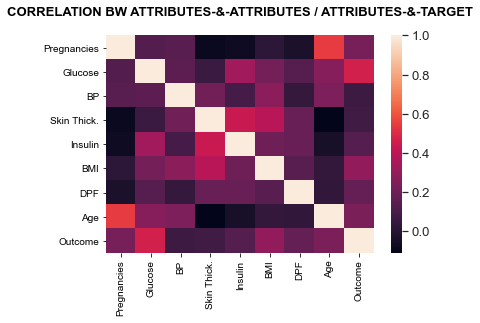

In [25]:
Plot_And_Save_Correlation_Matrix(corr_mat, 'correlation_matrix.png')

### PART 01
K-Means clustering is performed on the PIDD dataset for k (cluster size) given by the user. The value of k is taken as input from the user through a prompt. For the user given k, the re-worked PIDD data samples are clustered into k clusters. The initial k centers for the clustering algorithm are derived using the kmeans++ heuristic. The clustering of the data samples into k clusters is comprehended through the contingency matrix and the pair confusion matrix.

In [26]:
k = eval(input(' Enter k : '))

 Enter k : 15


In [27]:
centers, clusters, j_clust = KMeans(data_samples, k, verbose = True)

 ITERATION 1  | J_CLUST : 3.781782
 ITERATION 2  | J_CLUST : 3.466111
 ITERATION 3  | J_CLUST : 3.369227
 ITERATION 4  | J_CLUST : 3.324456
 ITERATION 5  | J_CLUST : 3.290372
 ITERATION 6  | J_CLUST : 3.273534
 ITERATION 7  | J_CLUST : 3.242916
 ITERATION 8  | J_CLUST : 3.213263
 ITERATION 9  | J_CLUST : 3.1775
 ITERATION 10  | J_CLUST : 3.15795
 ITERATION 11  | J_CLUST : 3.145484
 ITERATION 12  | J_CLUST : 3.138592
 ITERATION 13  | J_CLUST : 3.135222
 ITERATION 14  | J_CLUST : 3.132682
 ITERATION 15  | J_CLUST : 3.130586
 ITERATION 16  | J_CLUST : 3.129701
 ITERATION 17  | J_CLUST : 3.129442
 ITERATION 18  | J_CLUST : 3.129273
 ITERATION 19  | J_CLUST : 3.129273


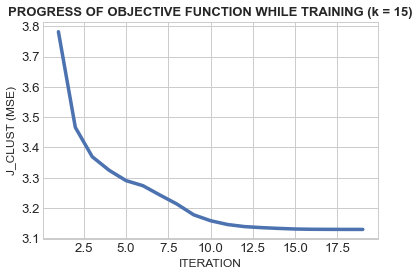

In [28]:
fontsize=12
plt.style.use('seaborn-whitegrid')
currentAxis = plt.gca()
graph = currentAxis.plot(list(range(1, 1+len(j_clust))), j_clust, linewidth=3.5)
plt.xlabel('ITERATION', fontsize=fontsize)
plt.ylabel('J_CLUST (MSE)', fontsize=fontsize)
plt.title('PROGRESS OF OBJECTIVE FUNCTION WHILE TRAINING (k = ' + str(k) + ')', fontsize=13, fontweight='bold')
filename = 'plot_jclust_part1_k' + str(k) + '.png'
plt.savefig(filename)

In [29]:
contingency_mat = Contingency_Matrix(clusters)
contingency_mat

array([[15,  8],
       [31, 35],
       [17, 74],
       [11, 43],
       [20, 39],
       [18, 16],
       [29, 32],
       [ 1, 11],
       [ 3, 68],
       [39, 13],
       [20, 17],
       [19, 12],
       [10,  7],
       [33, 42],
       [ 2, 83]], dtype=int32)

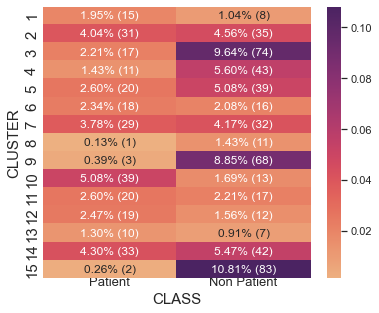

In [30]:
filename = 'conting_mat_part1_k' + str(k) + '.jpg'
Plot_And_Save_Contingency_Matrix(contingency_mat, filename)

In [31]:
pair_conf_mat = Pair_Confusion_Matrix (data_samples, centers)
pair_conf_mat

array([[ 15671,   7844],
       [144857, 126156]], dtype=int32)

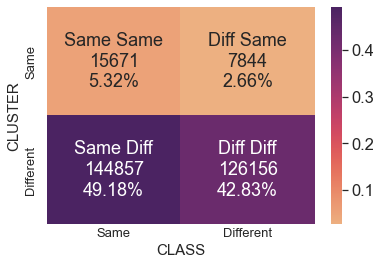

In [32]:
filename = 'pair_conf_mat_part1_k' + str(k) + '.jpg'
Plot_And_Save_Pair_Confusion_Matrix(pair_conf_mat, filename)

### PART 02
Performance of the obtained clustering is provided using available ground truth values and without using the ground truth values. Among the metrics that use the ground truth values RI, ARI, MI, NMI, homogeneity, completeness and V measure are evaluated. Among the metrics that do not use the ground truth values silhouette coefficient, Calinski Harabasz Index and Davies Bouldin Index are evaluated.

For the value of k given in the last part and hence the obtained clusters and cluster centers, this part computes and prints the 10 evaluation metrics, out of which 7 use the ground truth values as given in the dataset.

In [33]:
print(' +++ CLUSTERING PERFORMANCE USING GROUND TRUTH VALUES +++')
print('   RI (Random Index) :', RI(data_samples, centers))
print('   ARI (Adjusted Random Index) :', ARI(clusters))
print('   MI (Mutual Information) :', MI(clusters))
print('   NMI (Normalized Mutual Information) :', NMI(clusters))
print('   Homogeneity :', Homogeneity(clusters))
print('   Completeness :', Completeness(clusters))
print('   V Measure :', V_Measure(clusters))

+++ CLUSTERING PERFORMANCE USING GROUND TRUTH VALUES +++
   RI (Random Index) : 0.4815
   ARI (Adjusted Random Index) : 0.036
   MI (Mutual Information) : 0.1839
   NMI (Normalized Mutual Information) : 0.0788
   Homogeneity : 0.197
   Completeness : 0.0492
   V Measure : 0.0787


In [34]:
print(' +++ CLUSTERING PERFORMANCE WITHOUT USING GROUND TRUTH VALUES +++')
print('   Silhouette Coefficient :', Silhouette_Coefficient(data_samples, centers, clusters))
print('   Calinski-Harabasz Index :', Calinski_Harabasz_Index(data_samples, centers, clusters))
print('   Davies-Bouldin Index :', Davies_Bouldin_Index(data_samples, centers, clusters))

+++ CLUSTERING PERFORMANCE WITHOUT USING GROUND TRUTH VALUES +++
   Silhouette Coefficient : 0.1305
   Calinski-Harabasz Index : 83.7177
   Davies-Bouldin Index : 1.6096


### PART 03
The most suitable value of cluster size, k is determined by varying k and evaluating internal indices (like silhouette coefficient and Calinski Harabasz Index) on the obtained clusters and cluster centers.

The cluster size k is varied between the values low and high. This is done three times with different evaluation metrics to determine the optimal values of k in different cases.

Silhouette Coefficient : For each value of k between low and high, clustering is performed 3 times and the average of the silhouette coefficients obtained in each pass is recorded as the average silhouette coefficient for that value of k. Finally average silhouette coefficient v/s 
k graph is plotted and the optimal value of k at which the average value of the metric is the highest is reported.

Calinski Harabasz Index : For each value of k between low and high, clustering is performed 3 times and the average of the Calinski Harabasz Indices obtained in each pass is recorded as the average Calinski Harabasz Index for that value of k. Finally average Calinski Harabasz Index v/s k graph is plotted and the optimal value of k at which the average value of the metric is the highest is reported.

Wang's Method of Cross‐Validation : For each value of k between low and high, Wang's
Method of Cross‐Validation was performed with 10 permutations and |S1|:|S2|:|S3|=3:3:4 split of the data samples and the average disagreement ratio is recorded. Finally, a graph of average disagreement ratio v/s k is plotted and the optimal value of k at which the average value of disagreement ratio is the least is reported.

In [35]:
metric_track_record = Find_Most_Suitable_K_Using_Silhouette_Coefficient(data_samples)
optimal_k = max(zip(metric_track_record.values(), metric_track_record.keys()))[1]
print('\n OPTIMAL VALUE OF k BY USING SILHOUETTE COEFFICIENT :', optimal_k)

 k : 2 | Silhouette Coefficient : 0.1732
 k : 3 | Silhouette Coefficient : 0.1905
 k : 4 | Silhouette Coefficient : 0.1807
 k : 5 | Silhouette Coefficient : 0.1667
 k : 6 | Silhouette Coefficient : 0.1731
 k : 7 | Silhouette Coefficient : 0.1619
 k : 8 | Silhouette Coefficient : 0.1719
 k : 9 | Silhouette Coefficient : 0.161
 k : 10 | Silhouette Coefficient : 0.1561
 k : 11 | Silhouette Coefficient : 0.1435
 k : 12 | Silhouette Coefficient : 0.1532
 k : 13 | Silhouette Coefficient : 0.1544
 k : 14 | Silhouette Coefficient : 0.1502
 k : 15 | Silhouette Coefficient : 0.157
 k : 16 | Silhouette Coefficient : 0.1444
 k : 17 | Silhouette Coefficient : 0.1469
 k : 18 | Silhouette Coefficient : 0.1433
 k : 19 | Silhouette Coefficient : 0.1444
 k : 20 | Silhouette Coefficient : 0.1401
 k : 21 | Silhouette Coefficient : 0.14
 k : 22 | Silhouette Coefficient : 0.1361
 k : 23 | Silhouette Coefficient : 0.1425
 k : 24 | Silhouette Coefficient : 0.1385
 k : 25 | Silhouette Coefficient : 0.1348
 k :

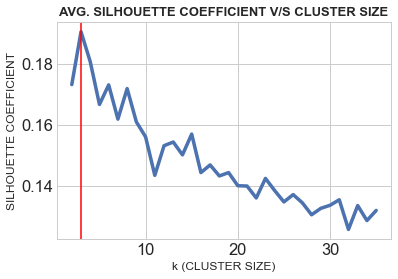

In [36]:
fontsize = 12
plt.style.use('seaborn-whitegrid')
currentAxis = plt.gca()
graph = currentAxis.plot(metric_track_record.keys(), metric_track_record.values(), linewidth=3.5)
plt.xlabel('k (CLUSTER SIZE)', fontsize=fontsize)
plt.ylabel('SILHOUETTE COEFFICIENT', fontsize=fontsize)
plt.title('AVG. SILHOUETTE COEFFICIENT V/S CLUSTER SIZE', fontsize=13, fontweight='bold')
plt.axvline(x = 3, color = 'red')
plt.savefig('plot_avg_sil_coeff_part3.png')

In [37]:
metric_track_record = Find_Most_Suitable_K_Using_CH_Index(data_samples)
optimal_k = max(zip(metric_track_record.values(), metric_track_record.keys()))[1]
print('\n OPTIMAL VALUE OF k BY USING CH-INDEX :', optimal_k)

 k : 2 | Calinski Harabasz Index : 146.7543
 k : 3 | Calinski Harabasz Index : 156.4842
 k : 4 | Calinski Harabasz Index : 131.142
 k : 5 | Calinski Harabasz Index : 116.4756
 k : 6 | Calinski Harabasz Index : 119.8422
 k : 7 | Calinski Harabasz Index : 117.2645
 k : 8 | Calinski Harabasz Index : 113.5172
 k : 9 | Calinski Harabasz Index : 103.989
 k : 10 | Calinski Harabasz Index : 101.2007
 k : 11 | Calinski Harabasz Index : 95.5564
 k : 12 | Calinski Harabasz Index : 94.918
 k : 13 | Calinski Harabasz Index : 90.5015
 k : 14 | Calinski Harabasz Index : 86.4328
 k : 15 | Calinski Harabasz Index : 83.0644
 k : 16 | Calinski Harabasz Index : 79.3063
 k : 17 | Calinski Harabasz Index : 78.5768
 k : 18 | Calinski Harabasz Index : 76.9571
 k : 19 | Calinski Harabasz Index : 74.2167
 k : 20 | Calinski Harabasz Index : 72.4651
 k : 21 | Calinski Harabasz Index : 71.6806
 k : 22 | Calinski Harabasz Index : 65.9792
 k : 23 | Calinski Harabasz Index : 65.9026
 k : 24 | Calinski Harabasz Index 

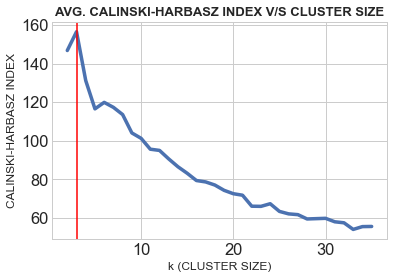

In [38]:
fontsize = 12
plt.style.use('seaborn-whitegrid')
currentAxis = plt.gca()
graph = currentAxis.plot(metric_track_record.keys(), metric_track_record.values(), linewidth=3.5)
plt.xlabel('k (CLUSTER SIZE)', fontsize=fontsize)
plt.ylabel('CALINSKI-HARBASZ INDEX', fontsize=fontsize)
plt.title('AVG. CALINSKI-HARBASZ INDEX V/S CLUSTER SIZE', fontsize=13, fontweight='bold')
plt.axvline(x = 3, color = 'red')
plt.savefig('plot_avg_chi_part3.png')

In [39]:
metric_track_record = Find_Most_Suitable_K_Using_Wangs_Cross_Validation_Method(data_samples)
optimal_k = min(zip(metric_track_record.values(), metric_track_record.keys()))[1]
print('\n OPTIMAL VALUE OF k BY WANG\'S VALIDATION METHOD :', optimal_k)

 k : 2 | Avg. Disagreement Ratio : 0.3766
 k : 3 | Avg. Disagreement Ratio : 0.2537
 k : 4 | Avg. Disagreement Ratio : 0.2195
 k : 5 | Avg. Disagreement Ratio : 0.2213
 k : 6 | Avg. Disagreement Ratio : 0.2021
 k : 7 | Avg. Disagreement Ratio : 0.1802
 k : 8 | Avg. Disagreement Ratio : 0.1734
 k : 9 | Avg. Disagreement Ratio : 0.1524
 k : 10 | Avg. Disagreement Ratio : 0.146
 k : 11 | Avg. Disagreement Ratio : 0.1366
 k : 12 | Avg. Disagreement Ratio : 0.1336
 k : 13 | Avg. Disagreement Ratio : 0.126
 k : 14 | Avg. Disagreement Ratio : 0.1186
 k : 15 | Avg. Disagreement Ratio : 0.1086
 k : 16 | Avg. Disagreement Ratio : 0.1202
 k : 17 | Avg. Disagreement Ratio : 0.1049
 k : 18 | Avg. Disagreement Ratio : 0.1087
 k : 19 | Avg. Disagreement Ratio : 0.0954
 k : 20 | Avg. Disagreement Ratio : 0.0935
 k : 21 | Avg. Disagreement Ratio : 0.0926
 k : 22 | Avg. Disagreement Ratio : 0.0884
 k : 23 | Avg. Disagreement Ratio : 0.0881
 k : 24 | Avg. Disagreement Ratio : 0.0808
 k : 25 | Avg. Disagr

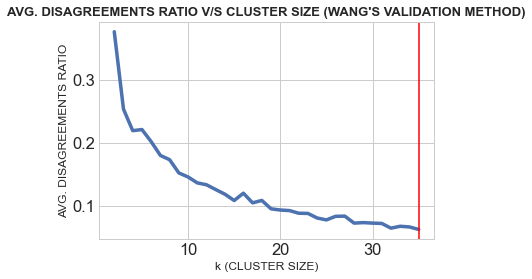

In [40]:
fontsize = 12
plt.style.use('seaborn-whitegrid')
currentAxis = plt.gca()
graph = currentAxis.plot(metric_track_record.keys(), metric_track_record.values(), linewidth=3.5)
plt.xlabel('k (CLUSTER SIZE)', fontsize=fontsize)
plt.ylabel('AVG. DISAGREEMENTS RATIO', fontsize=fontsize)
plt.title('AVG. DISAGREEMENTS RATIO V/S CLUSTER SIZE (WANG\'S VALIDATION METHOD)', fontsize=13, fontweight='bold')
plt.axvline(x = 35, color = 'red')
plt.savefig('plot_avg_disagr_ratio_part3.png')

### PART 04
The deviation/stability of the clustering outcome with respect to different random initializations of k cluster centers is studied through the Test‑A as given in the assignment. In order to reduce the variation in the evaluation metric chosen in the Test‑A (like NMI, ARI etc), a heuristic-based initialization routine is selected and Test‑A is re-performed and the deviation/stability of the clustering outcome are reported and compared with the former results.

A function that implements the Test‑A step-by-step as given in the assignment is written. Normalized Mutual Information (NMI) is chosen as the evaluation metric. The function takes an additional argument setting as input that indicates whether the test has to be performed in a random setting, where the initial cluster centers are assigned randomly, or in a heuristic setting, where the initial cluster centers are determined using some heuristic-based initialization routine. The heuristic that we have chosen to initialize the k cluster centers under the heuristic setting is k‑means﹢﹢.

In [41]:
k = eval(input(' Enter k : '))

 Enter k : 7


In [42]:
avg_metric_values = Test_A(data_samples, k, setting = 'random')

 PASS 1 	| AVG NMI : 0.0906309
 PASS 2 	| AVG NMI : 0.0949694
 PASS 3 	| AVG NMI : 0.0882453
 PASS 4 	| AVG NMI : 0.0920771
 PASS 5 	| AVG NMI : 0.079941
 PASS 6 	| AVG NMI : 0.0806179
 PASS 7 	| AVG NMI : 0.0973336
 PASS 8 	| AVG NMI : 0.0872253
 PASS 9 	| AVG NMI : 0.0886615
 PASS 10 	| AVG NMI : 0.0881075
 PASS 11 	| AVG NMI : 0.0843271
 PASS 12 	| AVG NMI : 0.082981
 PASS 13 	| AVG NMI : 0.0824758
 PASS 14 	| AVG NMI : 0.0861313
 PASS 15 	| AVG NMI : 0.0880253
 PASS 16 	| AVG NMI : 0.1037687
 PASS 17 	| AVG NMI : 0.0846131
 PASS 18 	| AVG NMI : 0.0916076
 PASS 19 	| AVG NMI : 0.0856234
 PASS 20 	| AVG NMI : 0.0883374
 PASS 21 	| AVG NMI : 0.0849169
 PASS 22 	| AVG NMI : 0.0829792
 PASS 23 	| AVG NMI : 0.0910196
 PASS 24 	| AVG NMI : 0.0833855
 PASS 25 	| AVG NMI : 0.0864801
 PASS 26 	| AVG NMI : 0.0881856
 PASS 27 	| AVG NMI : 0.0927057
 PASS 28 	| AVG NMI : 0.0922936
 PASS 29 	| AVG NMI : 0.0854273
 PASS 30 	| AVG NMI : 0.0826519
 PASS 31 	| AVG NMI : 0.0868199
 PASS 32 	| AVG NMI

In [43]:
mean = np.mean(avg_metric_values)
std_dev = np.std(avg_metric_values)
print('MEAN (AVG. NMI) :', round(mean, 7), ' | ', 'STD DEV (AVG. NMI) :', round(std_dev, 7))

MEAN (AVG. NMI) : 0.0876546  |  STD DEV (AVG. NMI) : 0.0043408


In [44]:
avg_metric_values = Test_A(data_samples, k, setting = 'heuristic')

 PASS 1 	| AVG NMI : 0.0897563
 PASS 2 	| AVG NMI : 0.0923174
 PASS 3 	| AVG NMI : 0.0862789
 PASS 4 	| AVG NMI : 0.0967324
 PASS 5 	| AVG NMI : 0.0802537
 PASS 6 	| AVG NMI : 0.0904708
 PASS 7 	| AVG NMI : 0.0883274
 PASS 8 	| AVG NMI : 0.0868447
 PASS 9 	| AVG NMI : 0.0864006
 PASS 10 	| AVG NMI : 0.089044
 PASS 11 	| AVG NMI : 0.0895343
 PASS 12 	| AVG NMI : 0.0909647
 PASS 13 	| AVG NMI : 0.0941076
 PASS 14 	| AVG NMI : 0.0865894
 PASS 15 	| AVG NMI : 0.0864686
 PASS 16 	| AVG NMI : 0.0876682
 PASS 17 	| AVG NMI : 0.0845336
 PASS 18 	| AVG NMI : 0.0921621
 PASS 19 	| AVG NMI : 0.0907739
 PASS 20 	| AVG NMI : 0.086894
 PASS 21 	| AVG NMI : 0.0865704
 PASS 22 	| AVG NMI : 0.086918
 PASS 23 	| AVG NMI : 0.0826436
 PASS 24 	| AVG NMI : 0.0877374
 PASS 25 	| AVG NMI : 0.0968985
 PASS 26 	| AVG NMI : 0.0912903
 PASS 27 	| AVG NMI : 0.0862671
 PASS 28 	| AVG NMI : 0.0937852
 PASS 29 	| AVG NMI : 0.0856456
 PASS 30 	| AVG NMI : 0.0855721
 PASS 31 	| AVG NMI : 0.086214
 PASS 32 	| AVG NMI :

In [45]:
mean = np.mean(avg_metric_values)
std_dev = np.std(avg_metric_values)
print('MEAN (AVG. NMI) :', round(mean, 7), ' | ', 'STD DEV (AVG. NMI) :', round(std_dev, 7))

MEAN (AVG. NMI) : 0.0882053  |  STD DEV (AVG. NMI) : 0.0038775
